# Домашнее задание 2

__Дедлайн: 1.11.2023, 23:59__

Файлы должны иметь имя HW1_ФАМИЛИЯ.ipynb, где ФАМИЛИЯ - Ваша фамилия русскими буквами.

Решение каждой задачи необходимо поместить после её условия.

Пожалуйста, пишите свои решения чётко и понятно.
При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться **без ошибок**.

Во всех задачах, где требуется сравнить методы, требуется аккуратное офрмление графиков, если Вы их будете строить, и комментарии к графикам (кто кого быстрее и когда сходится, какие интересные моменты Вы видите на графиках, как Вы их можете объяснить). Аналогично, требуются комментарии в случае, если Вы сравниваете время работы.

Суммарное количество баллов: 16

In [10]:
import numpy as np
import cvxpy as cvx
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import LinearOperator
import matplotlib.pyplot as plt
#import jax
#jax.config.update("jax_enable_x64", True)

%matplotlib inline

## Задача 1. Tensor Factorization [8]


В данной задаче Вам предлагается познакомиться с примером использользования CVXPY для решения выпуклых задач, а также идеей альтернированной оптимизации (alternating optimization), также называемой в попеременной оптимизации.


Хорошо известна задача матричной факторизации, цель которой представить матрицу $X \in \mathbb{R}^{m\times n}$ в виде произведения двух (или более) матриц $U\in \mathbb{R}^{m \times r}$ и $V\in\mathbb{R}^{r\times n}$, таким образом чтобы $X\approx UV$ и $r\ll \min\{m,n\}$. В некоторых случаях эта задача может быть просто решена. В частности, если искать такие матрицы $U$ и $V$, которые минимизируют $\|X-UV\|^2_F$, то решение может быть явно найдено через разложение SVD. Если $n,m$ большие, то такое разложение позволяет существенно уменьшить размер памяти для хранения (вместо $nm$ чисел храним $(n+m)r$) и ускорить вычисление произведение матрицы на вектор.

Существенно более сложной задачей является представление тензора в виде произведения тензоров. Пусть тензор $T\in \mathbb{R}^{N\times M \times K}$. Тогда задачей факторизацией тензора $T$ является поиск матриц $X\in \mathbb{R}^{N\times R},Y\in \mathbb{R}^{M\times R},Z\in \mathbb{R}^{K\times R}$, таких что $T\approx \sum\limits_{r=1}^R x_r \circ y_r \circ z_r$ и $R\ll \min(N,M,K)$, где $x_r, y_r, z_r$ - стобцы матриц $X, Y, Z$ и $x_r \circ y_r \circ z_r$ есть тензор размерности $N\times M \times K$ с элементами $(x_r \circ y_r \circ z_r)(i,j,k)=x_{ir} y_{jr} z_{kr}.$ Заметим, что такое представление позволит хранить нам $(N+M+K)R$ чисел вместо $NMK$. На данный момент задача факторизации может быть записана в следующем виде:


\begin{align*}
\label{1}
& \min_{X\in \mathbb{R}^{N\times R},Y\in \mathbb{R}^{M\times R},Z\in \mathbb{R}^{K\times R}} \sum\limits_{i,j,k=1}^{N, M,K} \left(T_{ijk} - \sum\limits_{r=1}^R x_{ir} y_{jr} z_{kr}\right)^2 \\
\end{align*}

Однако мы будем искать разреженные матрицы $X,Y,Z$. Для этого к задаче выше добавим поэлементный $\ell_1$ регуляриатор на каждую из матриц:
\begin{align*}
\label{2}
& \min_{X\in \mathbb{R}^{N\times R},Y\in \mathbb{R}^{M\times R},Z\in \mathbb{R}^{K\times R}} \frac{1}{\|T\|^2}\sum\limits_{i,j,k=1}^{N, M,K} \left(T_{ijk} - \sum\limits_{r=1}^R x_{ir} y_{jr} z_{kr}\right)^2 + \frac{\lambda}{NR}\|X\|_1 + \frac{\lambda}{MR}\|Y\|_1 + \frac{\lambda}{KR}\|Z\|_1 \\
\end{align*}

где $\|X\|_1=\sum |x_{ij}|$, $\|T\|^2 = \sum T_{ijk}^2$. Чем больше $R$ и чем меньше $\lambda>0$, тем точнее приближение, но и тем меньше выигрыш от такого разложения.

Такую задачу можно решать с помощью CVXPy, если воспользоваться идеей попеременной оптимизации (alternating optimization). Идея альтернированной оптимизиции состоит в том, чтобы при решении задачи $\min_{\mathbf{x}_j\in X_j} f(\mathbf{x}_1\dots \mathbf{x}_N)$ на каждой итерации решить $N$ задач оптимизации последовательно по каждому из блоков переменных при зафиксированных остальных.

Применяя эту идею к нашей задаче получим метод, в котором на каждой итерации сначала решается задача по $X$ при фиксированных $Y$ и $Z$, затем по $Y$ при фиксированных остальных переменных и, наконец, по $Z$ при фиксированных $X,Y$.

**Задачи**

1) Опишите эту задачу. Является она выпуклой или нет? Существует ли у нее решение? Если существует, то единственное ли оно?

2) Реализуйте с помощью CVXPY идею поперменной оптимизации для этой задачи. Поставьте ограничение на максимальное число итераций `max_iters=10000`.

3) Настройте ваш метод для малого примера приведённо ниже

4) Далее мы переходим к тестам на достаточно большом тензоре из файла `tensor.npy`. Загрузите данный тензор. Возьмите $R=4$ и $\lambda = 0.01$. Постройте график сходимости метода от итерации (убедитесь, что значение функции вышло на плато). Являются ли получившиеся решения разреженными?

5) При фиксированном $\lambda$ постройте график зависимости качества аппроксимации от $R$. Что можете сказать о балансе между точностью аппроксимации и её сложностью?

6) При фиксированном $R$ постройте графики зависимости разреженности факторов $X,Y,Z$ и качества аппроксимации от $\lambda$. Сделайте выводы.

Задача выпуклая, но решение не единстенно, если учитывать то, что мы последовательно решаем несколько задач оптимизации, фиксируя какие-то компоненты.

### Решение задачи 1:

Реализуем класс, который делает тензорную факторизации при помощи альтернированной оптимизации. В данном классе Вам нужно будет написать методы `argminX`, `argminY` и `argminZ`, которые решают нужные задачи оптимищации на каждой итерации, а также функцию `factorization_error`, которая возвращает ошибку аппроксимации (без учета регуляризаторов).

In [5]:
class TensorFactorization:
    def __init__(self, num_iters=1000, dim_factorization=10, regularization_parameter=0.1):
        """
        :param num_iters: int, iterations number for TensorFactorization
        :param dim_factorization: int, internal dimension of factorization (the parameter R above)
        :param regularization_parameter: float, parameter of regularization
        """
        self.dim_factorization = dim_factorization
        self.num_iters = num_iters
        self.regularization_parameter = regularization_parameter
        self.X = None
        self.Y = None
        self.Z = None

    def solve(self, tensor, X=None, Y=None, Z=None, print_logs=False):
        """
        :param tensor: np.array, tensor that should be factorized
        :param X, Y, Z: np.array or None, start point for factorization
        :param print_logs: bool, if True it prints results of optimization on each iteration
        :return: history of optimization
        """
        assert len(tensor.shape)==3, "Wrong tensor dimension"
        if X is None:
            self.X = np.random.rand(tensor.shape[0], self.dim_factorization)
        if Y is None:
            self.Y = np.random.rand(tensor.shape[1], self.dim_factorization)
        if Y is None:
            self.Z = np.random.rand(tensor.shape[2], self.dim_factorization)
        history = [self.factorization_error(tensor, self.X, self.Y, self.Z)]
        if print_logs:
            print("Iter\t|\tLoss")
        for i in range(self.num_iters):
            self._update(tensor)
            history.append(self.factorization_error(tensor, self.X, self.Y, self.Z))
            if print_logs:
                print("{}\t|\t{:.4f}".format(i + 1, history[-1]))
        return history

    def _update(self, tensor):
        """
        :param tensor: np.array, tensor that should be factorized
        """
        self.X = self.argminX(tensor)
        self.Y = self.argminY(tensor)
        self.Z = self.argminZ(tensor)

    @staticmethod
    def factorization_error(tensor, X, Y, Z):
        """
        :param tensor: np.array, tensor that should be factorized
        :param X, Y, Z: np.array or None, factors
        :return: norm of residual 1/||T||^2 * \sum_{i,j,k=1}^{N, M, K}(T_{ijk} - \sum_{r=1}^R x_{ir} y_{ir} z_{ir})^2
        """
        # YOUR CODE HERE
        tensor_norm = np.sum(tensor**2)
        sum_of_squares = 0
        for i in range(N):
            for j in range(M):
                for k in range(K):
                    inner_sum = 0
                    for r in range(R):
                        inner_sum += X[i, r] * Y[j, r] * Z[k, r]
                    sum_of_squares += (tensor[i, j, k] - inner_sum) ** 2
        
            
        return sum_of_squares/tensor_norm


    def argminX(self, tensor):
        """
        :param tensor: np.array, tensor that should be factorized
        :return: factor X
        """
        # YOUR CODE HERE
        N = tensor.shape[0]
        M = tensor.shape[1]
        K = tensor.shape[2]

        X = cvx.Variable((N, self.dim_factorization))
        main_sum = cvx.sum(cvx.sum([(tensor[:, :, i] - (X @ cvx.diag(self.Z[i, :])) @ self.Y.T)**2 for i in range(K)]))
        add_sum = self.regularization_parameter * cvx.norm(self.Y, 1) / np.prod(Y.shape) +\
                  self.regularization_parameter * cvx.norm(self.Z, 1) / np.prod(Z.shape) +\
                  self.regularization_parameter * cvx.norm(X, 1) / np.prod(X.shape)
        obj = main_sum / np.sum(tensor**2) + add_sum
        prob = cvx.Problem(cvx.Minimize(obj))
        prob.solve()
        return X.value
        pass




    def argminY(self, tensor):
        """
        :param tensor: np.array, tensor that should be factorized
        :return: factor Y
        """
        # YOUR CODE HERE
        N = tensor.shape[0]
        M = tensor.shape[1]
        K = tensor.shape[2]

        Y = cvx.Variable((M, self.dim_factorization))
        main_sum = cvx.sum(cvx.sum([(tensor[:, :, i] - self.X @ (Y @ cvx.diag(self.Z[i, :])).T)**2 for i in range(K)]))
        add_sum = self.regularization_parameter * cvx.norm(self.X, 1) / np.prod(X.shape) +\
                  self.regularization_parameter * cvx.norm(self.Z, 1) / np.prod(Z.shape) +\
                  self.regularization_parameter * cvx.norm(Y, 1) / np.prod(Y.shape)
        obj = main_sum / np.sum(tensor**2) + add_sum
        prob = cvx.Problem(cvx.Minimize(obj))
        prob.solve()
        return Y.value
        pass

       

    def argminZ(self, tensor):
        """
        :param tensor: np.array, tensor that should be factorized
        :return: factor Z
        """
        # YOUR CODE HERE
        N = tensor.shape[0]
        M = tensor.shape[1]
        K = tensor.shape[2]

        Z = cvx.Variable((K, self.dim_factorization))
        tensor_norm = np.sum(tensor ** 2)
        main_sum = cvx.sum(cvx.sum([(tensor[i, :, :] - self.Y @ (Z @ cvx.diag(self.X[i, :])).T)**2 for i in range(N)]))
        add_sum = self.regularization_parameter * cvx.norm(self.X, 1) / np.prod(X.shape) +\
                  self.regularization_parameter * cvx.norm(self.Y, 1) / np.prod(Y.shape) +\
                  self.regularization_parameter * cvx.norm(Z, 1) / np.prod(Z.shape)
        obj = main_sum / np.sum(tensor**2) + add_sum
        prob = cvx.Problem(cvx.Minimize(obj))
        prob.solve()
        return Z.value
        pass

    def get_factors(self):
        return self.X, self.Y, self.Z

In [6]:
np.random.seed(13)
N, M, K = 3, 4, 5
R = 2
X, Y, Z = [np.random.randn(N, R), np.random.randn(M, R), np.random.randn(K, R)]
random_tensor = np.random.randn(N, M, K)
assert np.abs(TensorFactorization.factorization_error(random_tensor, X, Y, Z) - 2.06910498) <= 1e-8, "Wrong implementation of `factorization_error`"

test_tensor = [[[(X[i,:] * Y[j, :] * Z[k, :]).sum() for k in range(K)] for j in range(M)] for i in range(N)]
test_tensor = np.array(test_tensor)

method = TensorFactorization(num_iters=10, dim_factorization=2, regularization_parameter=0)
test_history = method.solve(test_tensor)
assert test_history[-1] <= 1e-13, "Wrong solution"

In [8]:
# Место для Вашего решения
# Загрузка тензора и проверка на его примере
tensor = np.load('tensor.npy')
solver = TensorFactorization(num_iters=1000, dim_factorization=4, regularization_parameter=0.01)
history = solver.solve(test_tensor)

print(f"N={solver.X.shape}, M={solver.Y.shape}, K={solver.Z.shape}")

N=(3, 4), M=(4, 4), K=(5, 4)


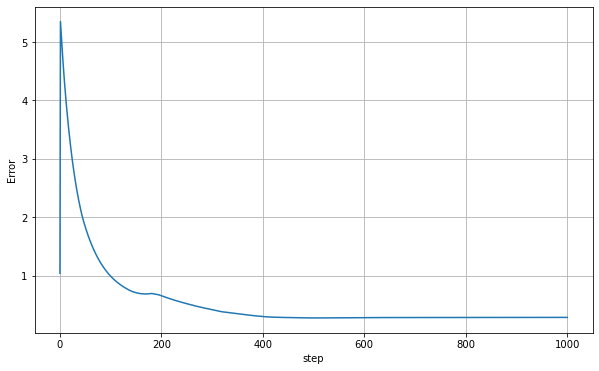

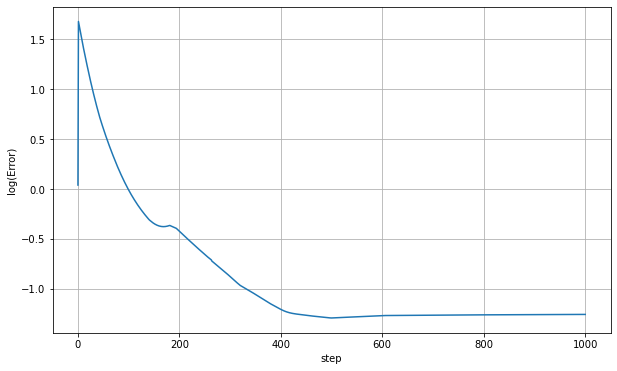

In [11]:
# график
errors = np.array(history)
steps = np.arange(len(errors))
plt.figure(figsize = (10, 6))
plt.plot(steps, errors)
plt.ylabel('Error')
plt.xlabel('step')
plt.grid()

errors = np.array(history)
steps = np.arange(len(errors))
plt.figure(figsize = (10, 6))
plt.plot(steps, np.log(errors))
plt.ylabel('log(Error)')
plt.xlabel('step')
plt.grid()

Как видно, график выходит на плато при ~600 иттерациях.

## Задача 2. More Jacobian for the Jacobian God [8]


В ряде задач нам важно уметь эффективно находить решение следующей системы уравнений:

$$(J_f^\top J_f + \delta I) h = g$$
где $g$ - некоторый известный вектор, $J_f \in \mathbb{R}^{m\times n}$ - якобиан некоторой функции $f:\mathbb{R}^n \rightarrow \mathbb{R}^m$ в некоторой точке $x$, $\delta>0$ - параметр регуляризации, $h$ - искомый вектор.


Задача выше эквивалентна решению задачи оптимизации:
$$\min_{h\in\mathbb{R}^n} \frac{1}{2} h^\top A h - g^\top h,$$
где $A=J_f^\top J_f + \delta I.$

В этом задании Вам предлагается сравнить два способа решения СЛАУ с якобианами:

1) Явно сформировать матрицу $A$ и решить систему линейных уравнений при помощи какого-либо разложения

2) Решить задачу оптимизации при помощи итеративного метода. Любой итеративный метод требует уметь только эффективно умножать матрицу на вектор, т.е. эффективно вычислять $(J_f^\top J_f + \delta I)$

В этом задании все якобианы, а также проиведения якобиан-вектор должны быть реализованы через `jax`. Не забывайте про `jax.jit`

**Задачи**

1) Реализуйте первый способ. Т.е. явно сформируйте матрицу $(J_f^\top J_f + \delta I)$ и решите систему линейных уравнений при помощи `numpy.linalg.solve`. При формировании якобиана учтите, что в наших примерах $m\gg n$.

2) На семинаре мы уже разобрали, что $J_f^\top z = \nabla_x g(x, z),$ где $\langle f(x), z\rangle, z\in\mathbb{R}^m$. Пользуясь этим результатом, покажите, как найти $J_f u$ как градиент скалярной функции?

3) Пользуясь функциями `jax.jvp` ($Jz$) и `jax.vjp` ($J^\top r$), реализуйте эффективное умножение матрицы $A$ на вектор. Используйте его, чтобы решить поставленную задачу оптимизации, пользуясь методом сопряженных градиентов (тут предлагается воспользоваться готовой реализацией `jax.scipy.sparse.linalg.cg`)

4) Проверьте, что два подхода дают практически один и тот же результат

5) Функция `get_test_function` из файла `test_functions.py` принимает на вход размерность $n$ и возвращает некоторую диффиренцируемую функцию $f:\mathbb{R}^n \rightarrow \mathbb{R}^{10n}$. Сравните по времени два подхода для различных размерностей $n$.

Во всех задачах возьмите $\delta = 10^{-5} n.$ Вектора $g$ и $x$ сгенерируйте случайным образом через `jax`

### Решение задачи 2:

Функция `solve_system`, которая строит явно матрицу $J_f(x)^\top J_f(x) + \delta I$ и решает систему при помощи `np.linalg.solve`

In [ ]:
def solve_system(vector_function, vector_x, vector_g, delta=0):
    """
    :param vector_function: callable, function f described above
    :param vector_x: np.array, the point at which Jacobian is calculated
    :param vector_g: np.array, the right hand of linear system
    :param delta: float, regularization parameter
    :return: solution of system
    """
    # YOUR CODE HERE
    pass

Функция `solve_opt_problem` решает задачу оптимиации при помощи метода сопряженных градиентов. Оболочка, требуемая для вызова готовой функции из `scipy`, уже реализована. Для его успешной работы остаётся реализовать только  функцию `jtj_vector_product`, которая принимает на вход $f, x, \delta$ и возвращает функцию $F(g) = (J_f(x)^\top J_f(x) + \delta I) g$ (не само значение функции $F$, а именно лямбда-функцию, которая реализует $F$).

In [ ]:
import jax
def solve_opt_problem(vector_function, vector_x, vector_g, delta=0, tol=1e-8):
    """
    :param vector_function: callable, function f described above
    :param vector_x: np.array, the point at which jacobian is calculated
    :param vector_g: np.array, the right hand of linear system
    :param delta: float, regularization parameter
    :param tol: float, tolerance
    :return: solution of optimization problem
    """
    Ax = jtj_vector_product(vector_function, vector_x, delta=delta)
    sol, _ = jax.scipy.sparse.linalg.cg(Ax, vector_g, tol=tol)
    return sol


def jtj_vector_product(vector_function, vector_x, delta=0):
    """
    Jacobiant-Transposed-Jacobian Vector Product
    :param vector_function: callable, function f described above
    :param vector_x: np.array, the point at which jacobian is calculated
    :param vector_g: np.array, the right hand of linear system
    :param delta: float, regularization parameter
    :return: callable, function that returns (J_f(x)^T J_f(x) + delta I) g without explicit matrix construction
    """
    # YOUR CODE HERE
    pass



In [ ]:
n = 10
delta =  1e-5 * n
np.random.seed(1)
key = jax.random.PRNGKey(42)
vector_x = jax.random.normal(key, (n,))
vector_g = jax.random.normal(key, (n,))

0.0001


In [ ]:
# Место для Вашего решения